In [1]:
import decimal
from collections import defaultdict
import matplotlib
import numpy as np
import itertools
import os
import pandas as pd
import datetime
from joblib import dump
import json
from matplotlib import pyplot as plt
from tqdm import tqdm
import glob
import pdb
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import roc_curve, auc
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, '../../scripts/modeling_toolbox/')
sys.path.insert(0, '../../')
import utils
from scripts.asset_processor import VideoAssetProcessor

%matplotlib notebook
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize']=[10,6]
pd.options.display.width = 0
pd.set_option('display.max_columns', None)

In [2]:
%matplotlib notebook

In [5]:
FEATURES_UL = ['size_dimension_ratio',
               'temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean',
               'temporal_histogram_distance-mean'
               ]

FEATURES_SL = ['size_dimension_ratio',
               'temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean',
               'temporal_histogram_distance-mean'
               ]
FEATURES_META = ['cat_cl_pred','ocsvm_pred']
FULL_FEATURES = list(set(FEATURES_UL + FEATURES_SL))
# Target variable, 1 represents Tamper, 0 is correct rendition
TARGET = ['target']

train_fraction = 0.85

In [7]:
# read data
data = utils.load_data('http://storage.googleapis.com/verification-models/data-new-metrics.csv')
# remove low bitrate renditions
data = data[~data.rendition.str.contains('bitrate')]
data = data[~data.rendition.str.contains('chroma')]
data
data = VideoAssetProcessor.rescale_to_resolution(data, FULL_FEATURES)
len_before = len(data)

Upscaling temporal_dct temporal_dct-mean
Upscaling temporal_gaussian_mse temporal_gaussian_mse-mean
Upscaling temporal_gaussian_difference temporal_gaussian_difference-mean
Upscaling temporal_histogram_distance temporal_histogram_distance-mean


In [8]:
# drop all columns without some of the features
data.dropna(axis=0, subset=FEATURES_SL+FEATURES_UL, inplace=True)
print(f'Removed {len_before - len(data)} NA rows')

Removed 0 NA rows


In [9]:
# split test and train making sure source and its renditions are not split
np.random.seed(1337)
master_ids = data.master_id.unique()
train_master_ids = np.random.choice(master_ids, int(train_fraction*master_ids.shape[0]), replace=False)
train_idx = np.isin(data.master_id, train_master_ids)
train_data = data[train_idx]
test_idx = ~data.index.isin(train_data.index)
test_data = data[test_idx]
y_test = test_data['target']
y_train = train_data['target']
# save split
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

In [10]:
# renditions by type
print('Test data top rendition types:')
test_data.groupby('rendition').rendition.count().sort_values().tail(15)

Test data top rendition types:


rendition
144p_watermark              598
240p_vignette               598
240p_watermark              598
144p_vignette               598
480p                        598
144p_rotate_90_clockwise    598
360p_black_and_white        598
360p_flip_horizontal        598
1080p_black_and_white       598
360p_rotate_90_clockwise    598
144p_flip_horizontal        598
360p_vignette               598
360p_watermark              598
360p                        598
1080p_watermark             598
Name: rendition, dtype: int64

In [11]:
train_data[FULL_FEATURES].describe()

,temporal_histogram_distance-mean,temporal_threshold_gaussian_difference-mean,temporal_dct-mean,temporal_gaussian_difference-mean,temporal_gaussian_mse-mean,size_dimension_ratio
count,1.596770e+05,159677.000000,1.596770e+05,1.596770e+05,1.596770e+05,159677.000000
mean,1.576267e+05,22050.595498,1.179664e+07,6.206473e+09,1.635786e+04,2.957005
std,5.388140e+05,25631.407899,2.526161e+07,1.351193e+10,4.642541e+04,1.372465
min,0.000000e+00,0.000000,1.386768e+02,2.254349e+04,1.019019e-04,0.016935
25%,2.368788e+03,1019.777778,2.588567e+05,1.617230e+08,7.432839e+01,2.134054
50%,6.386786e+03,4732.888889,1.769912e+06,8.077247e+08,9.319454e+02,2.962725
75%,3.258062e+04,44150.888889,9.740293e+06,4.884506e+09,8.772522e+03,3.566859
max,8.703013e+06,129600.000000,4.743106e+08,1.707865e+11,1.030569e+06,19.957878


In [12]:
(train_data['size']/(train_data['dimension_x']*train_data['dimension_y'])).describe()

count    159677.000000
mean          2.957005
std           1.372465
min           0.016935
25%           2.134054
50%           2.962725
75%           3.566859
max          19.957878
dtype: float64

In [13]:
# class balance, 1 is tampered rendition, 0 is accurate rendition
print('Test data class balance:')
test_data.groupby('target').target.count()

Test data class balance:


target
0     3006
1    25187
Name: target, dtype: int64

In [14]:
# test renditions by type
print('Test data FPS renditions count:')
test_data[test_data.rendition.str.contains('fps')]['target']

Test data FPS renditions count:


id
1080p_watermark-856x856_24-30fps_gpu/-apHZNnZSL4.mp4            1
1080p_rotate_90_clockwise_24-60fps/-ewkJboodaE.mp4              1
1080p_vignette_25-30fps/4PpxM7P2M1c.mp4                         1
144p_24-60fps/4f49m5mZE3M.mp4                                   0
1080p_flip_horizontal_30-24fps_gpu/3fSUvsWTqpA.mp4              1
1080p_25-30fps_gpu/DjL38nRWbkE.mp4                              0
1080p_flip_vertical_24-60fps_gpu/nmI2HLSirHY.mp4                1
144p_24-30fps/0b9uySaNopg.mp4                                   0
144p_vignette_30-24fps_gpu/GOh-RhD_p2Y.mp4                      1
144p_25-30fps_gpu/2X-b-7gWMQI.mp4                               0
144p_rotate_90_counterclockwise_30-24fps_gpu/VUtmahnh1nM.mp4    1
1080p_vignette_24-60fps_gpu/-QmLoLkURHw.mp4                     1
1080p_rotate_90_clockwise_24-30fps/-QmLoLkURHw.mp4              1
1080p_watermark-856x856_24-30fps/1jKx0x-ymYM.mp4                1
144p_flip_horizontal_24-60fps/iSleTtlfTCw.mp4                   1
144p_vi

In [15]:
### OCSVM MODEL
# fit outlier detector to tampered videos as a bigger class
x_train_ul = np.asarray(train_data[FEATURES_UL][train_data.target==0])
x_test_ul = np.asarray(test_data[FEATURES_UL])
# scale the data
scaler = StandardScaler()
x_train_ul = scaler.fit_transform(x_train_ul)
x_test_ul = scaler.transform(x_test_ul)
# fit the model
oc_svm = svm.OneClassSVM(kernel='rbf', gamma=0.3, nu=0.001, cache_size=5000)
oc_svm.fit(x_train_ul)
def ocsvm_score_converter(score):
    return 1-1/(1+np.exp(-score))
# get predictions on test and convert them with sigmoid function to (0,1) interval
test_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(x_test_ul))
# add predictions to train data
train_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(np.asarray(train_data[FEATURES_UL])))
test_data['ocsvm_pred_label'] = (-oc_svm.predict(x_test_ul)+1)/2
# dump scaler and model
dump(scaler, '../output/models/OCSVM_StandardScaler_v2.joblib')
dump(oc_svm, '../output/models/OCSVM_v2.joblib')

['../output/models/OCSVM_v2.joblib']

In [16]:
### CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_binary = CatBoostClassifier(**cb_params)
# Fit model
cat_x_train = np.asarray(train_data[FEATURES_SL])
catboost_binary.fit(cat_x_train, train_data['target'], cat_features)
cat_x_test = np.asarray(test_data[FEATURES_SL])
test_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_test)[:,1]
test_data['cat_cl_y_pred_label'] = catboost_binary.predict(cat_x_test)
# add predictions to train data
train_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_train)[:,1]
catboost_binary.save_model('../output/models/CB_Binary_v2.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)


0:	learn: 0.5399321	total: 68.4ms	remaining: 34.1s
1:	learn: 0.4216214	total: 87.5ms	remaining: 21.8s
2:	learn: 0.3333191	total: 107ms	remaining: 17.6s
3:	learn: 0.2725725	total: 125ms	remaining: 15.5s
4:	learn: 0.2215147	total: 143ms	remaining: 14.2s
5:	learn: 0.1852581	total: 163ms	remaining: 13.4s
6:	learn: 0.1588564	total: 182ms	remaining: 12.8s
7:	learn: 0.1412237	total: 201ms	remaining: 12.4s
8:	learn: 0.1266762	total: 223ms	remaining: 12.2s
9:	learn: 0.1158311	total: 242ms	remaining: 11.9s
10:	learn: 0.1067820	total: 261ms	remaining: 11.6s
11:	learn: 0.0996552	total: 287ms	remaining: 11.7s
12:	learn: 0.0935356	total: 314ms	remaining: 11.8s
13:	learn: 0.0877039	total: 339ms	remaining: 11.8s
14:	learn: 0.0833700	total: 359ms	remaining: 11.6s
15:	learn: 0.0797610	total: 379ms	remaining: 11.5s
16:	learn: 0.0770786	total: 409ms	remaining: 11.6s
17:	learn: 0.0749408	total: 430ms	remaining: 11.5s
18:	learn: 0.0723486	total: 448ms	remaining: 11.3s
19:	learn: 0.0706224	total: 468ms	remai

164:	learn: 0.0431490	total: 4.41s	remaining: 8.95s
165:	learn: 0.0431082	total: 4.44s	remaining: 8.93s
166:	learn: 0.0430367	total: 4.46s	remaining: 8.9s
167:	learn: 0.0430153	total: 4.48s	remaining: 8.86s
168:	learn: 0.0429435	total: 4.51s	remaining: 8.83s
169:	learn: 0.0428899	total: 4.53s	remaining: 8.8s
170:	learn: 0.0428568	total: 4.57s	remaining: 8.79s
171:	learn: 0.0428285	total: 4.61s	remaining: 8.79s
172:	learn: 0.0427965	total: 4.66s	remaining: 8.8s
173:	learn: 0.0427730	total: 4.7s	remaining: 8.8s
174:	learn: 0.0427253	total: 4.75s	remaining: 8.81s
175:	learn: 0.0426890	total: 4.78s	remaining: 8.81s
176:	learn: 0.0426534	total: 4.83s	remaining: 8.81s
177:	learn: 0.0426250	total: 4.86s	remaining: 8.79s
178:	learn: 0.0425821	total: 4.88s	remaining: 8.76s
179:	learn: 0.0425254	total: 4.9s	remaining: 8.72s
180:	learn: 0.0424868	total: 4.92s	remaining: 8.67s
181:	learn: 0.0424477	total: 4.94s	remaining: 8.63s
182:	learn: 0.0424103	total: 4.95s	remaining: 8.58s
183:	learn: 0.0423

326:	learn: 0.0387907	total: 8.21s	remaining: 4.34s
327:	learn: 0.0387801	total: 8.24s	remaining: 4.32s
328:	learn: 0.0387530	total: 8.26s	remaining: 4.29s
329:	learn: 0.0387287	total: 8.29s	remaining: 4.27s
330:	learn: 0.0387100	total: 8.31s	remaining: 4.24s
331:	learn: 0.0386917	total: 8.33s	remaining: 4.22s
332:	learn: 0.0386703	total: 8.35s	remaining: 4.19s
333:	learn: 0.0386560	total: 8.37s	remaining: 4.16s
334:	learn: 0.0386391	total: 8.38s	remaining: 4.13s
335:	learn: 0.0386167	total: 8.4s	remaining: 4.1s
336:	learn: 0.0386036	total: 8.42s	remaining: 4.07s
337:	learn: 0.0385802	total: 8.44s	remaining: 4.04s
338:	learn: 0.0385636	total: 8.46s	remaining: 4.02s
339:	learn: 0.0385588	total: 8.48s	remaining: 3.99s
340:	learn: 0.0385424	total: 8.49s	remaining: 3.96s
341:	learn: 0.0385183	total: 8.51s	remaining: 3.93s
342:	learn: 0.0384958	total: 8.53s	remaining: 3.9s
343:	learn: 0.0384736	total: 8.54s	remaining: 3.87s
344:	learn: 0.0384368	total: 8.56s	remaining: 3.84s
345:	learn: 0.0

494:	learn: 0.0367676	total: 11.8s	remaining: 119ms
495:	learn: 0.0367675	total: 11.8s	remaining: 95.4ms
496:	learn: 0.0367674	total: 11.8s	remaining: 71.5ms
497:	learn: 0.0367673	total: 11.9s	remaining: 47.6ms
498:	learn: 0.0367672	total: 11.9s	remaining: 23.8ms
499:	learn: 0.0367672	total: 11.9s	remaining: 0us


In [17]:
# voting model
test_data['meta_voting_pred_label'] = np.where(test_data['ocsvm_pred_label']==0, 0, test_data['cat_cl_y_pred_label'])
test_data[['meta_voting_pred_label','cat_cl_y_pred_label','ocsvm_pred_label']]
#test_data['meta_voting_pred'] = (test_data['cat_cl_pred']*2 + test_data['ocsvm_pred'])/2

,meta_voting_pred_label,cat_cl_y_pred_label,ocsvm_pred_label
id,,,
720p_black_and_white/ALTlJUod2jU.mp4,1,1,1.0
144p_rotate_90_clockwise/g0HJWlDb-ao.mp4,1,1,1.0
720p_rotate_90_clockwise/E1Q-z2emjWQ.mp4,1,1,1.0
720p_flip_horizontal/rgchsYcBVWI.mp4,1,1,1.0
1080p_vignette/ikq4BH64p_I.mp4,1,1,1.0
720p_rotate_90_clockwise/9jmHc2dMA7o.mp4,1,1,1.0
1080p_black_and_white/WzWJpCfhhgU.mp4,1,1,1.0
720p/d0lOMYVQsPs.mp4,0,0,0.0
144p_black_and_white/beVH1-KiSbM.mp4,1,1,1.0


In [18]:
def multi_model_perf(y, y_preds, labs, cols=['green', 'orange', 'red', 'black', 'blue', 'yellow', 'magenta'], report_threshold=[0.5]):
    plt.figure()
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Model ROC comparison')
    for y_pred, lab, col, preset_t in zip(y_preds, labs, cols, report_threshold):
        fpr, tpr, thresh = roc_curve(y, y_pred, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=col,
                 lw=2, label=lab+' AUC=%0.2f' % roc_auc)
        print('##################')
        print(f'{lab} ROC threshold: {preset_t}')
        print(f'{lab} classification report:')
        print(classification_report(y, y_pred>preset_t))
        print(f'{lab} confusion matrix:')
        print(confusion_matrix(y, y_pred>preset_t))
    plt.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>


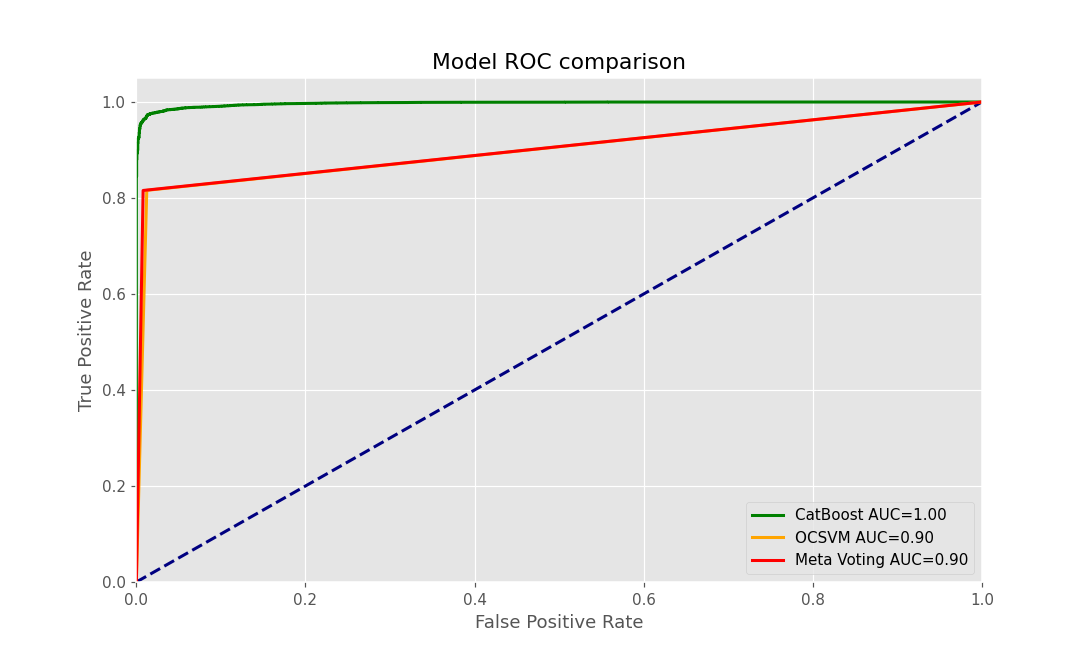

##################
CatBoost ROC threshold: 0.5
CatBoost classification report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3006
           1       0.99      0.99      0.99     25187

    accuracy                           0.98     28193
   macro avg       0.95      0.96      0.96     28193
weighted avg       0.98      0.98      0.98     28193

CatBoost confusion matrix:
[[ 2818   188]
 [  295 24892]]
##################
OCSVM ROC threshold: 0.5
OCSVM classification report:
              precision    recall  f1-score   support

           0       0.39      0.99      0.56      3006
           1       1.00      0.82      0.90     25187

    accuracy                           0.83     28193
   macro avg       0.69      0.90      0.73     28193
weighted avg       0.93      0.83      0.86     28193

OCSVM confusion matrix:
[[ 2969    37]
 [ 4635 20552]]
##################
Meta Voting ROC threshold: 0.5
Meta Voting classification repo

In [19]:
multi_model_perf(y_test, [test_data['cat_cl_pred'], test_data['ocsvm_pred_label'], test_data['meta_voting_pred_label']], 
              ['CatBoost', 'OCSVM','Meta Voting'], report_threshold=[0.5,0.5,0.5])

In [20]:
print('Hardest rendition types:')
test_data[test_data.cat_cl_y_pred_label!=test_data.target].groupby('rendition').rendition.count().sort_values().tail(15)

Hardest rendition types:


rendition
1080p_watermark-856x856     6
144p_watermark              6
1080p_watermark-345x114     7
360p_watermark-856x856      7
144p_black_and_white        9
720p                       10
720p_watermark-345x114     20
480p                       25
360p                       32
480p_watermark-345x114     38
240p_watermark-345x114     43
240p                       45
360p_watermark-345x114     50
144p_watermark-345x114     66
144p                       71
Name: rendition, dtype: int64

In [22]:
print('Feature importance:')
importance = catboost_binary.get_feature_importance(prettified=True)
importance['Feature Name']=np.array(FULL_FEATURES)[importance['Feature Id'].values.astype(np.int32)]
importance

Feature importance:


,Feature Id,Importances,Feature Name
0,4,18.886075,temporal_gaussian_mse-mean
1,1,17.911920,temporal_threshold_gaussian_difference-mean
2,2,17.485504,temporal_dct-mean
3,0,16.427163,temporal_histogram_distance-mean
4,5,16.268878,size_dimension_ratio
5,3,13.020459,temporal_gaussian_difference-mean


FPS Renditions


<IPython.core.display.Javascript object>


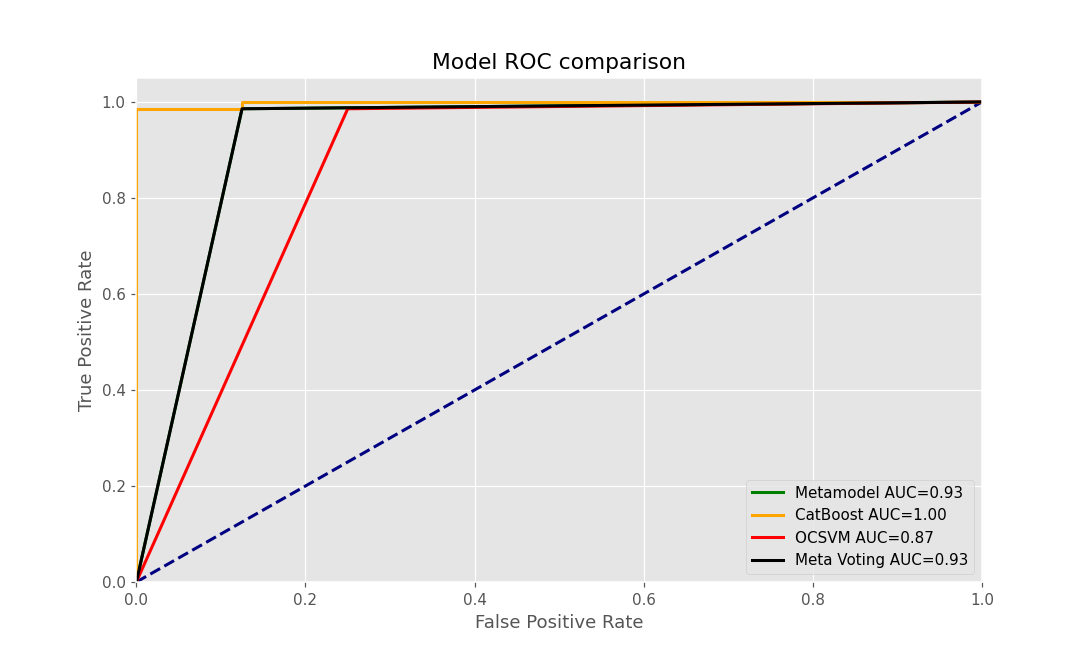

##################
Metamodel ROC threshold: 0.5
Metamodel classification report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.97      0.99      0.98        71

    accuracy                           0.97        87
   macro avg       0.95      0.93      0.94        87
weighted avg       0.97      0.97      0.97        87

Metamodel confusion matrix:
[[14  2]
 [ 1 70]]
##################
CatBoost ROC threshold: 0.5
CatBoost classification report:
              precision    recall  f1-score   support

           0       1.00      0.69      0.81        16
           1       0.93      1.00      0.97        71

    accuracy                           0.94        87
   macro avg       0.97      0.84      0.89        87
weighted avg       0.95      0.94      0.94        87

CatBoost confusion matrix:
[[11  5]
 [ 0 71]]
##################
OCSVM ROC threshold: 0.5
OCSVM classification report:
              precis

In [23]:
print('FPS Renditions')
fps_test_idx = test_data.id.str.contains('fps')
y_test_fps = test_data[fps_test_idx]['target']
multi_model_perf(y_test_fps, [test_data[fps_test_idx]['meta_voting_pred_label'], test_data[fps_test_idx]['cat_cl_pred'], test_data[fps_test_idx]['ocsvm_pred_label'],
                      test_data[fps_test_idx]['meta_voting_pred_label']], 
              ['Metamodel','CatBoost', 'OCSVM',
               'Meta Voting'], report_threshold=[0.5,0.5,0.5,0.5])